In [2]:
# Extension of the PyTorch tutorial to train a simple classifier.
#  https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
#
#  The general structure of the network is based on LeNet-5.
#  Gradient-Based Learning applied to Document Recognition, LeCun et al 1998.

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# Helper function to show a grid of images.
def imshow(img):
    img   = img / 2 + 0.5      # un-normalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show

In [4]:
# GPU setup.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [114]:
# Size of training batch.
nBatch = 16

# Size of test set 
nFinal = 64

In [115]:
transform = transforms.Compose(
    [ transforms.ToTensor()
    , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset  = torchvision.datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
trainload = torch.utils.data.DataLoader(trainset, batch_size=nBatch, shuffle=True,  num_workers=2)

testset   = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testload  = torch.utils.data.DataLoader(testset,  batch_size=nBatch, shuffle=False, num_workers=2)

# Scan through the test set in bigger chunks.
finalload = torch.utils.data.DataLoader(testset,  batch_size=nFinal, shuffle=False, num_workers=2)

classes   = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  car horse  frog  deer truck   cat  deer  deer  deer truck  ship plane  frog  frog   dog  deer


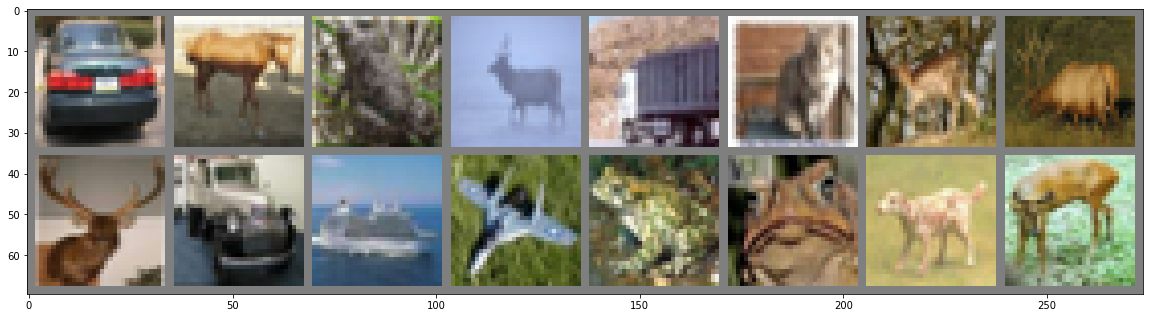

In [102]:
# Print out some sample training images.
dataiter = iter(trainload)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(nBatch)))

In [103]:
# Print total accuracy of network.
def print_accuracy_total(net):
    total   = 0
    correct = 0
    with torch.no_grad():
        for data in testload:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('  accuracy: %d %%' % (100 * correct / total))

In [131]:
# Print per-class accuracy of network.
def print_accuracy_classes(net):
    total   = 0
    correct = 0
    
    class_correct = list(0. for i in range(10))
    class_total   = list(0. for i in range(10))  
    with torch.no_grad():
        for data in testload:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            c = (predicted == labels).squeeze()
            for i in range(nBatch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label]   += 1

    print('  accuracy: %d %%' % (100 * correct / total))
    for i in range(10):
        print('   %-5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [173]:
# Define the network.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,  32, 5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)  
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [174]:
# Instantiate the network and copy it to the device.
net = Net()

# Enable data parallelism on all GPUs,
#  but this will just make it slower for small batch sizes.
# net = nn.DataParallel(net)

net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [175]:
# Define the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [180]:
# Train the network for a few epochs.
#  Execute this a few times until it stops getting better.
for epoch in range(4):
    print('* Epoch %d' % (epoch + 1))
    
    running_loss = 0.0
    for i, data in enumerate(trainload, 0):
        # get the inputs. data is list of input, label
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 iterations
            print('  loss: %.3f' % (running_loss / 2000))
            running_loss = 0.0

    print_accuracy_classes(net)
            
print('Finished')

* Epoch 1
  loss: 0.590
  accuracy: 69 %
   plane: 83 %
   car  : 86 %
   bird : 62 %
   cat  : 46 %
   deer : 70 %
   dog  : 59 %
   frog : 73 %
   horse: 70 %
   ship : 69 %
   truck: 73 %
* Epoch 2
  loss: 0.563
  accuracy: 70 %
   plane: 73 %
   car  : 83 %
   bird : 49 %
   cat  : 49 %
   deer : 77 %
   dog  : 61 %
   frog : 74 %
   horse: 75 %
   ship : 83 %
   truck: 78 %
* Epoch 3
  loss: 0.540
  accuracy: 70 %
   plane: 65 %
   car  : 78 %
   bird : 52 %
   cat  : 46 %
   deer : 75 %
   dog  : 65 %
   frog : 82 %
   horse: 69 %
   ship : 87 %
   truck: 79 %
* Epoch 4
  loss: 0.522
  accuracy: 70 %
   plane: 74 %
   car  : 87 %
   bird : 64 %
   cat  : 43 %
   deer : 69 %
   dog  : 57 %
   frog : 78 %
   horse: 69 %
   ship : 85 %
   truck: 73 %
Finished


In [181]:
print_accuracy_classes(net)

  accuracy: 70 %
   plane: 74 %
   car  : 87 %
   bird : 64 %
   cat  : 43 %
   deer : 69 %
   dog  : 57 %
   frog : 78 %
   horse: 69 %
   ship : 85 %
   truck: 73 %


In [182]:
print_accuracy_total(net)

  accuracy: 70 %


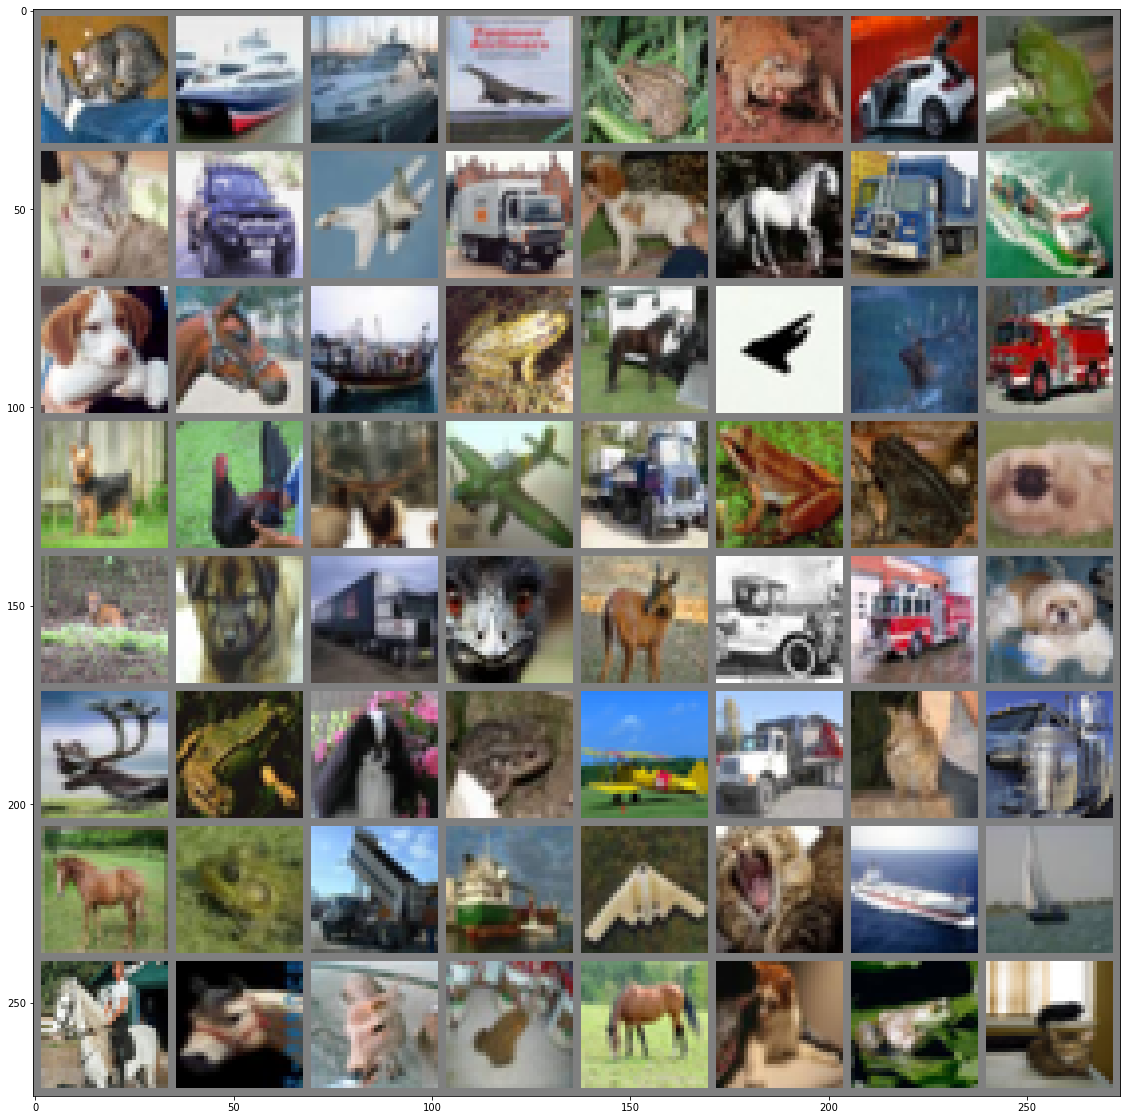

In [189]:
# Apply the network to some final images.
dataiter = iter(finalload)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [190]:
# Print the classification labels.
for y in range(8):
    print(' '.join('%-6s' % classes[labels[y * 8 + j]] for j in range(8)))

cat    ship   ship   plane  frog   frog   car    frog  
cat    car    plane  truck  dog    horse  truck  ship  
dog    horse  ship   frog   horse  plane  deer   truck 
dog    bird   deer   plane  truck  frog   frog   dog   
deer   dog    truck  bird   deer   car    truck  dog   
deer   frog   dog    frog   plane  truck  cat    truck 
horse  frog   truck  ship   plane  cat    ship   ship  
horse  horse  deer   frog   horse  cat    frog   cat   


In [191]:
# Print the predictions, along with whether each prediction was true or not.
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

for y in range(8):
    print(' '.join('%-6s' % classes[predicted[y * 8 + j]] for j in range(8)))
print()

for y in range(8):
    print(' '.join('%-6s' % str((labels[y * 8 + j] == predicted[y * 8 + j]).item()) for j in range(8)))

cat    car    ship   plane  deer   frog   car    frog  
cat    car    cat    truck  dog    horse  truck  ship  
dog    horse  ship   frog   plane  plane  deer   truck 
deer   bird   deer   plane  truck  frog   frog   bird  
bird   frog   truck  frog   deer   car    truck  dog   
plane  frog   dog    frog   plane  truck  cat    truck 
horse  frog   truck  ship   frog   cat    plane  ship  
dog    dog    dog    cat    horse  frog   deer   plane 

True   False  True   True   False  True   True   True  
True   True   False  True   True   True   True   True  
True   True   True   True   False  True   True   True  
False  True   True   True   True   True   True   False 
False  False  True   False  True   True   True   True  
False  True   True   True   True   True   True   True  
True   True   True   True   False  True   False  True  
False  False  False  False  True   False  False  False 


In [192]:
# Print out a selection of images with the given label.
def showThings(label):
    # Number of source images to scan through looking for examples
    # that have the desired label.
    nScan = 2048
    
    # Loader for example images. 
    loadExample = torch.utils.data.DataLoader(testset,  batch_size=nScan, shuffle=False, num_workers=1)
    iterExample = iter(loadExample)

    # Load a batch of example images.
    images, labels = iterExample.next()

    # Copy the images to the device for scoring.
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    # Keep only the images that get classified as the desired label.
    isKeepIndices = [i for i in range(0, predicted.size(0)) 
                        if classes[predicted[i]] == label]

    tTakeIndices  = torch.as_tensor(isKeepIndices[:64])
    tImages       = torch.index_select(images, 0, tTakeIndices)

    # Show the "selected things"
    imshow(torchvision.utils.make_grid(tImages))

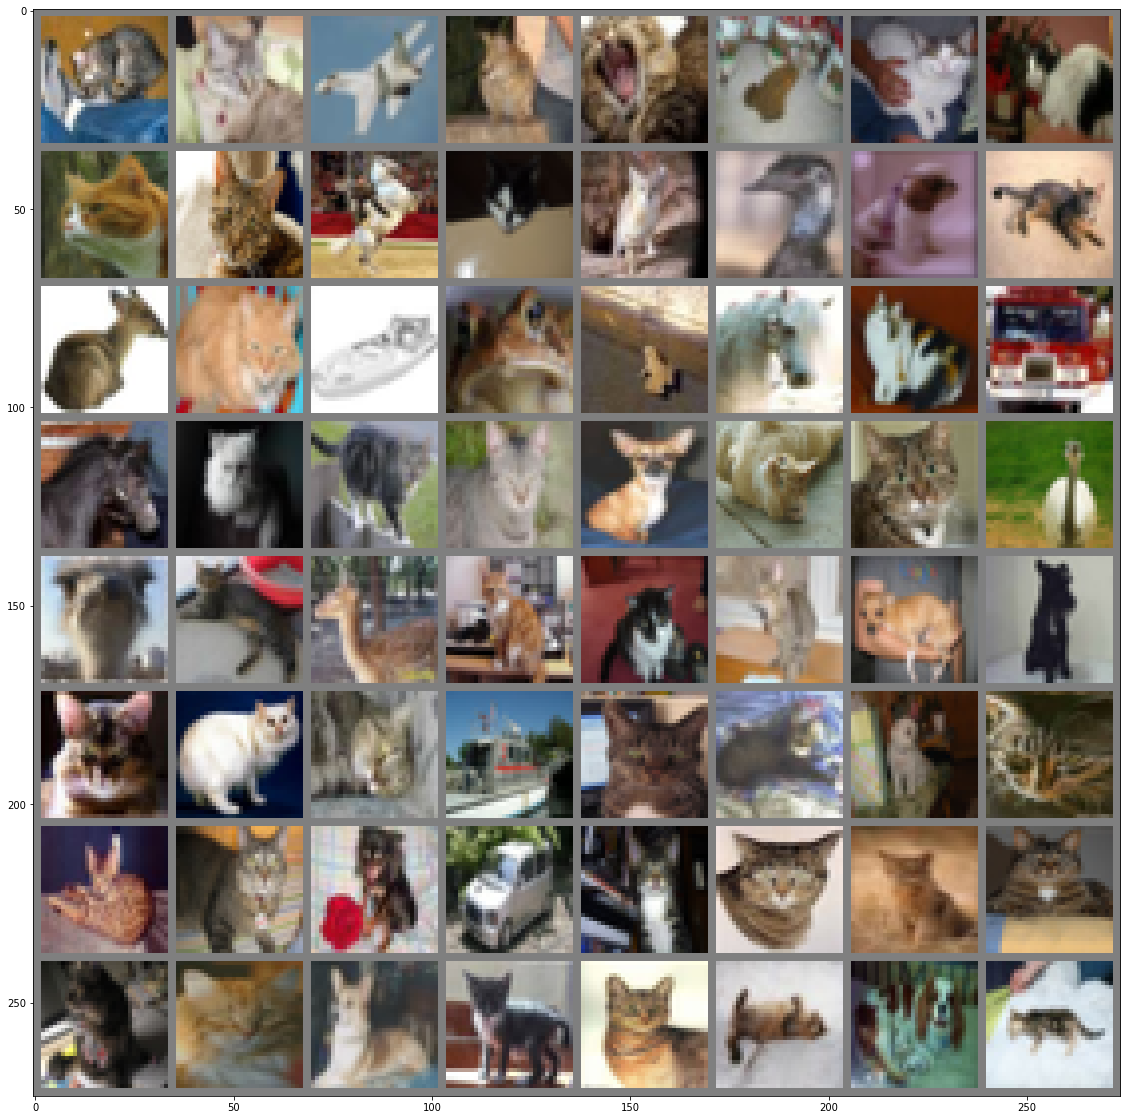

In [193]:
showThings('cat')

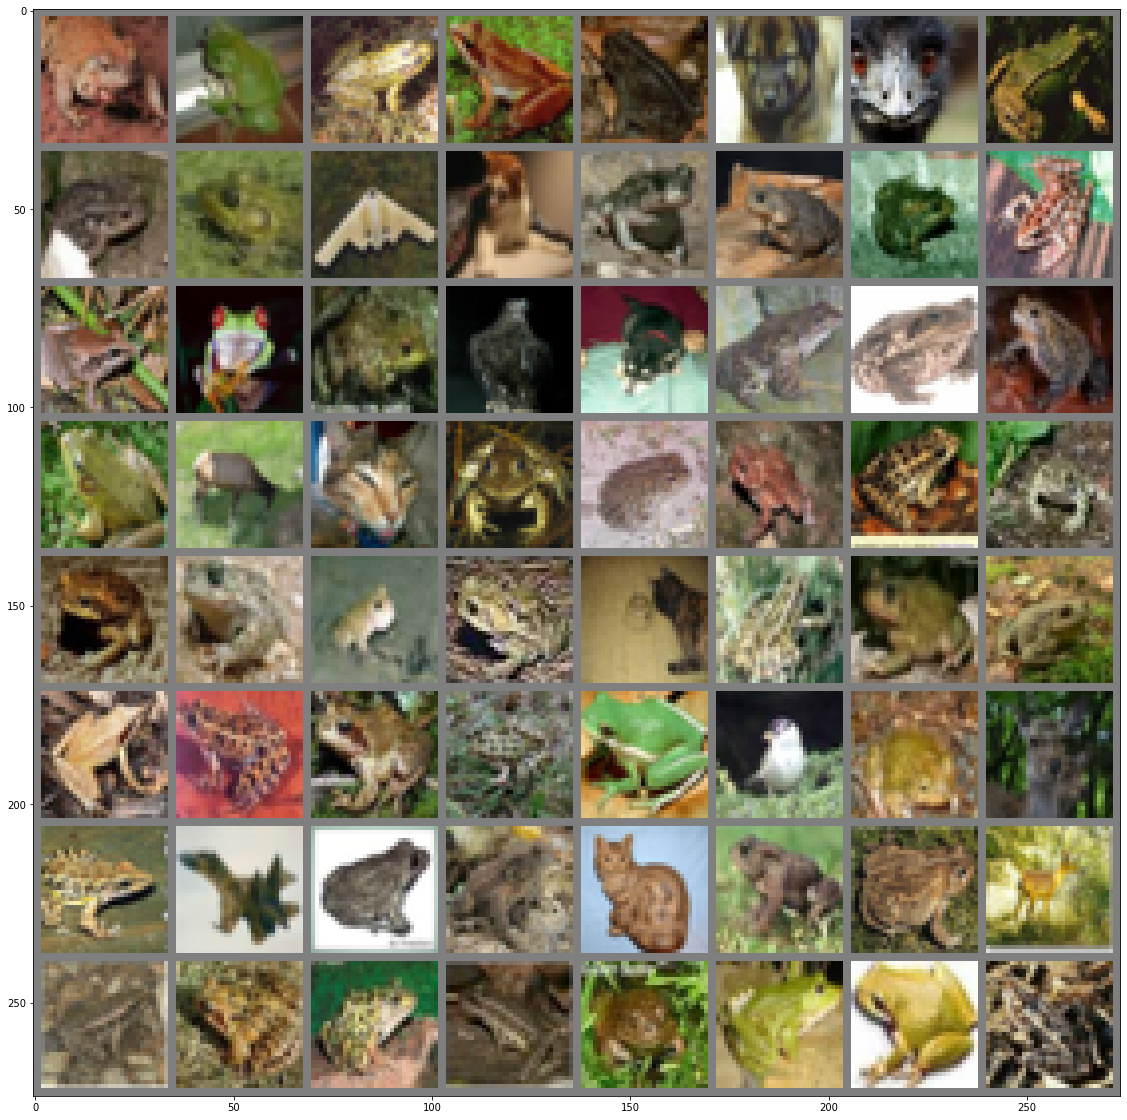

In [194]:
showThings('frog')

In [145]:
# Save the model.
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)